In [1]:
import plumed
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
def wham(bias,
        *,
        frame_weight=None,
        traj_weight=None,
        T: float = 1.0,
        maxiter: int = 1000,
        threshold: float = 1e-40,
        verbose: bool = False):
    """Weighted histogram analysis method

    Args:
        bias (_type_): Bias with shape (nframes, ntraj). Each trajectory should have the same number of frames
        frame_weight (_type_, optional): Weight for each frame. Defaults to None.
        traj_weight (_type_, optional): Weight for each trajectory. Defaults to None.
        T (float, optional): This is k_B*T where k_B is the Boltzmann constant and T is the temperature. Defaults to 1.0.
        maxiter (int, optional): Maximum number of iterations. Defaults to 1000.
        threshold (float, optional): Convergence criterion. Defaults to 1e-40.
        verbose (bool, optional): Prints out some things if True. Defaults to False.

    Returns:
        _type_: _description_
    """

    nframes = bias.shape[0]
    ntraj = bias.shape[1]

    # default values
    if frame_weight is None:
        frame_weight = np.ones(nframes)
    if traj_weight is None:
        traj_weight = np.ones(ntraj)

    assert len(traj_weight) == ntraj
    assert len(frame_weight) == nframes

    # divide by T once for all
    shifted_bias = bias/T
    # track shifts
    shifts0 = np.min(shifted_bias, axis=0)
    shifted_bias -= shifts0[np.newaxis,:]
    shifts1 = np.min(shifted_bias, axis=1)
    shifted_bias -= shifts1[:,np.newaxis]

    # do exponentials only once
    expv = np.exp(-shifted_bias)

    Z = np.ones(ntraj)

    Zold = Z

    if verbose:
        print("WHAM: start\n")
    for nit in range(maxiter):
        # find unnormalized weights
        weight = 1.0/np.matmul(expv, traj_weight/Z)*frame_weight
        # update partition functions
        Z = np.matmul(weight, expv)
        # normalize the partition functions
        Z /= np.sum(Z*traj_weight)
        # monitor change in partition functions
        eps = np.sum(np.log(Z/Zold)**2)
        Zold = Z
        if verbose:
            print(f"WHAM: iteration {nit} eps {eps}\n")
        if eps < threshold:
            break
    nfev=nit
    logW = np.log(weight) + shifts1

    if verbose:
        print("WHAM: end")

    return {"logW":logW, "logZ":np.log(Z)-shifts0, "nit":nit, "eps":eps}

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/amritagos/micromamba/envs/plumedenv/lib/libplumedKernel.so" +++
/tmp/ipykernel_498067/4218528255.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data.append(plumed.read_as_pandas(str(p)))
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/amritagos/micromamba/envs/plumedenv/lib/libplumedKernel.so" +++
/tmp/ipykernel_498067/4218528255.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data.append(plumed.read_as_pandas(str(p)))
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/amritagos/micromamba/envs/plumedenv/lib/libplumedKernel.so" +++
/tmp/ipykernel_498067/4218528255.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future versio

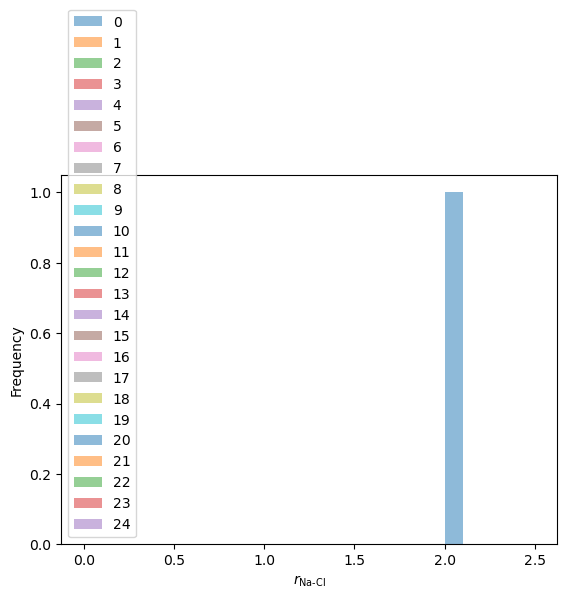

In [16]:
import itertools

# For two-dimensional CVs, check out 
# https://www.plumed-tutorials.org/lessons/21/003/data/Solution.html

# Just to sort the paths so that each index corresponds to the COLVAR trajectory
def extract_number(p):
    try:
        return int(p.name.split('_')[-1])
    except (IndexError, ValueError):
        return float('100') 

colvar_files = [f for f in Path("../results/sampling_2/").glob("*/COLVAR*")]
colvar_files = sorted(colvar_files, key=extract_number)
colvar_files

data = [] # Contains the CVs and bias values 
n_frames = 1

color_cycler = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, ax = plt.subplots()

for i,p in enumerate(colvar_files):
    data.append(plumed.read_as_pandas(str(p)))
    color = next(color_cycler)
    ax.hist(data[i].d1[n_frames*i:n_frames*(i+1)], color=color, alpha=0.5, label=f"{i}")
ax.set_xlabel(r"$r_{\text{Na-Cl}}$")
ax.set_ylabel("Frequency")
ax.legend()
# The plot shows which regions are sampled by each simulation
plt.show()